#Проведите анализ с помощью SSA в любом из временных рядов

Singular Spectrum Analysis (SSA) - это метод анализа временных рядов, который позволяет выделить скрытые сигналы и структуры в данных. Он основан на преобразовании временного ряда в набор компонент, называемых собственными временными рядами или сингулярными компонентами.

Процесс SSA состоит из следующих шагов:

1. **Встраивание**: Исходный временной ряд разбивается на траектории, которые представляют собой матрицу Ханкеля. Это делается путем формирования матрицы, где каждый столбец состоит из последовательных значений ряда, а каждая строка - из смещенных на одно значение последовательности. Таким образом, каждая траектория представляет собой последовательность значений, которые близки во времени.

2. **Сингулярное разложение**: Выполняется сингулярное разложение матрицы Ханкеля, которое разлагает ее на сингулярные значения, сингулярные векторы и их транспонированные сопряженные.

3. **Выбор компонент**: Из полученных сингулярных значений выбираются наиболее значимые, отражающие структуры и сигналы в исходных данных. Количество выбираемых компонент определяется пользователем и зависит от анализируемого временного ряда.

4. **Реконструкция**: Выбранные сингулярные компоненты комбинируются в реконструированный временной ряд. Это делается путем умножения матриц сингулярных векторов и сингулярных значений, а затем объединения рядов из реконструированного временного ряда.

SSA имеет несколько преимуществ при анализе временных рядов. Он позволяет выделять основные сигналы, идентифицировать тренды, сезонные компоненты, циклы и шумы в данных. SSA также обладает свойством линейности, что облегчает интерпретацию результатов и позволяет рассчитывать статистические свойства каждой компоненты.

SSA может быть применен для различных задач анализа временных рядов, таких как прогнозирование, декомпозиция, фильтрация и обнаружение аномалий. Он нашел применение в различных областях, включая финансы, экономику, климатологию, биологию и другие.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
data = pd.read_csv('international-airline-passengers.csv')

Временной ряд "international-airline-passengers" представляет собой данные о месячном количестве пассажиров международных авиалиний, зарегистрированных с января 1949 года по декабрь 1960 года. Этот ряд часто используется в задачах прогнозирования и анализа временных рядов.

Описание данных:
- Период: Январь 1949 года - Декабрь 1960 года.
- Частота: Месячная (12 наблюдений в году).
- Переменная: Количество пассажиров, измеренное в тысячах.




In [ ]:
data.head()

,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
passengers = data['Count']

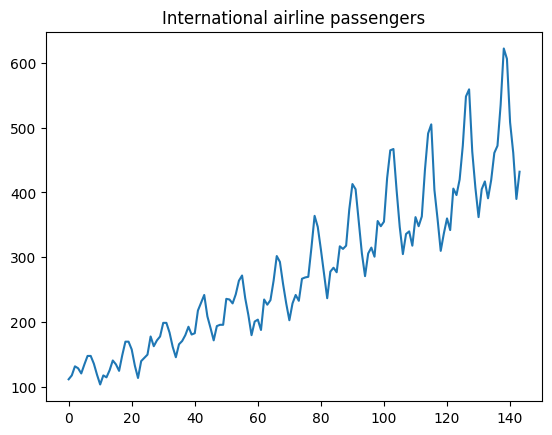

In [ ]:
plt.plot(passengers)
plt.title('International airline passengers')
plt.show()

Создание класса Singular Spectrum Analysis (SSA)

In [ ]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

Строим графики для определения оптимального размера окна

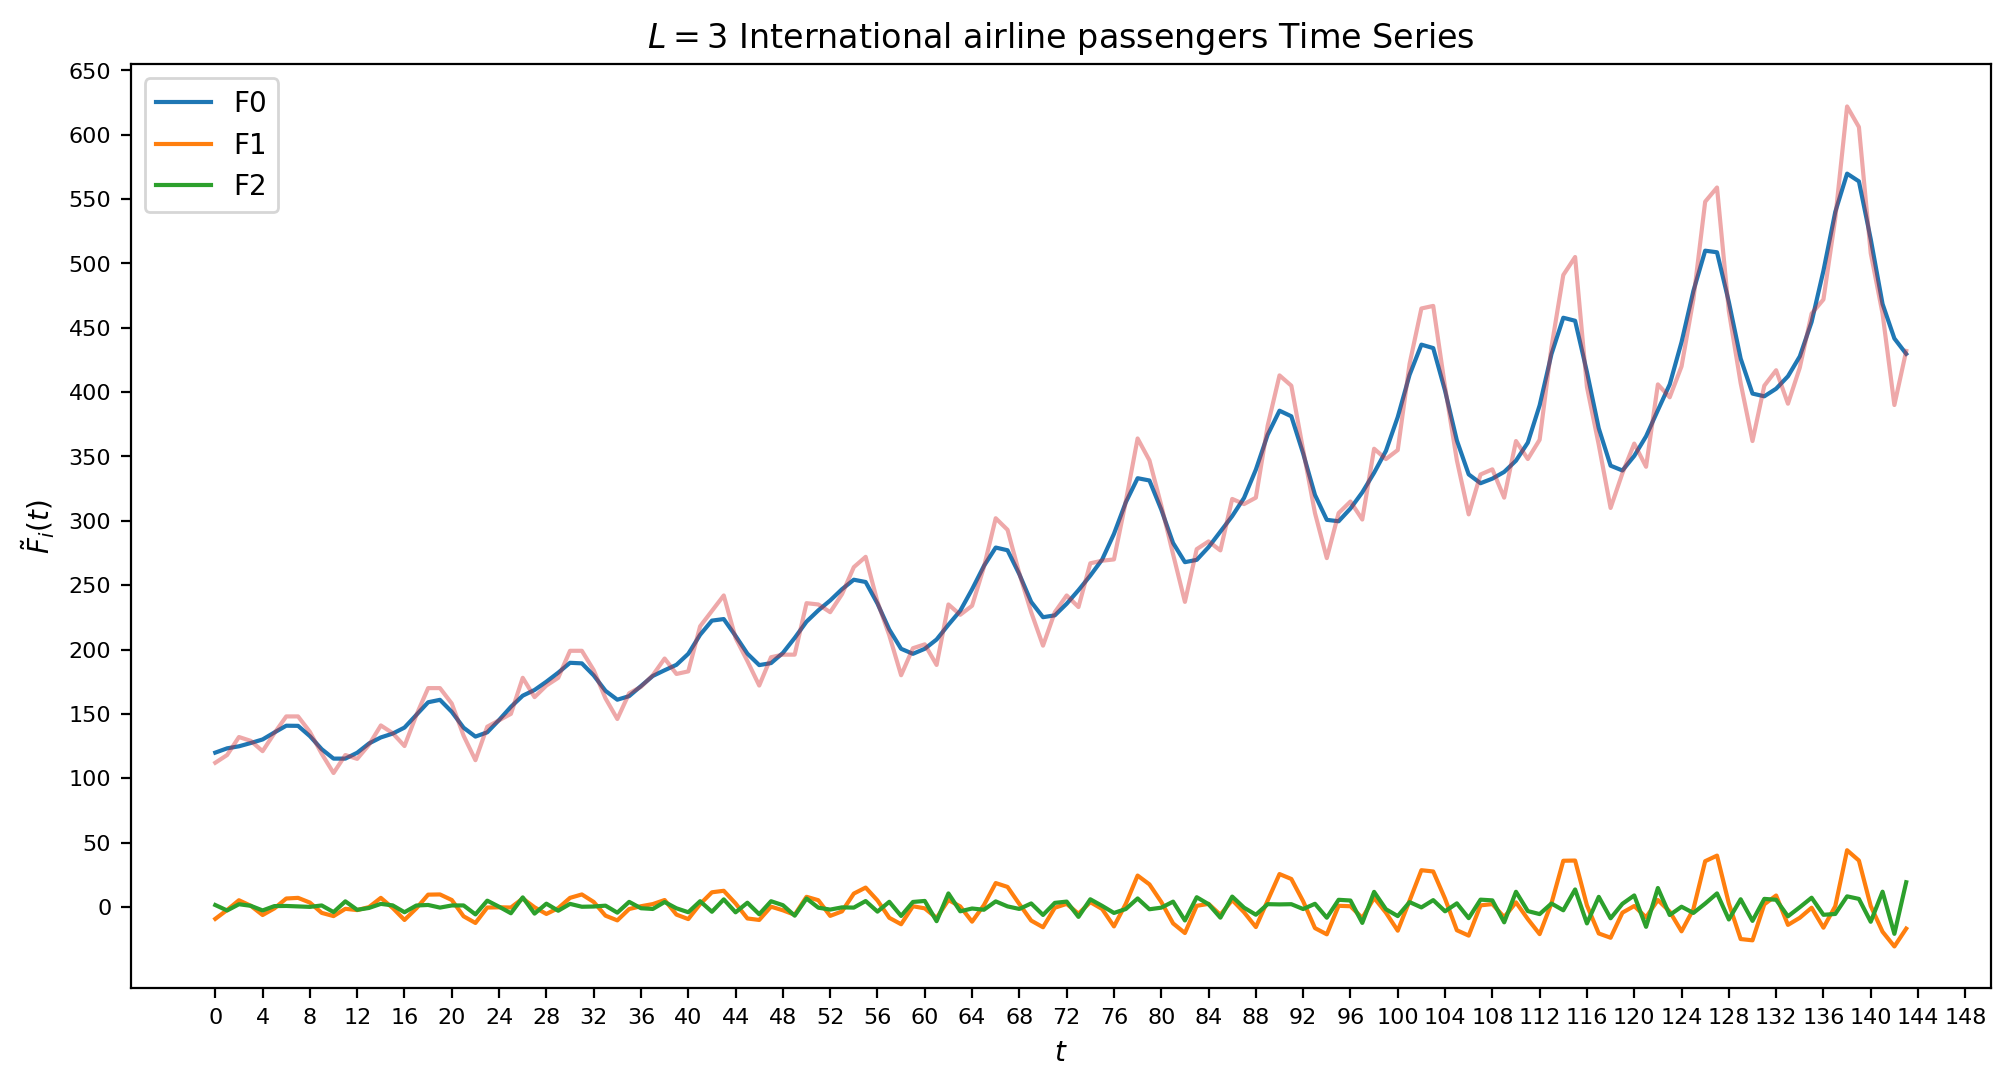

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi = 200)
plt.xticks(range(0, 160, 4))
plt.yticks(range(0, 700, 50))
ax.tick_params(axis='x', labelsize= 8)
ax.tick_params(axis='y', labelsize= 8)
F_ssa_L3 = SSA(passengers, 3)
F_ssa_L3.components_to_df().plot(ax=ax)
F_ssa_L3.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=3$ International airline passengers Time Series")
plt.show()

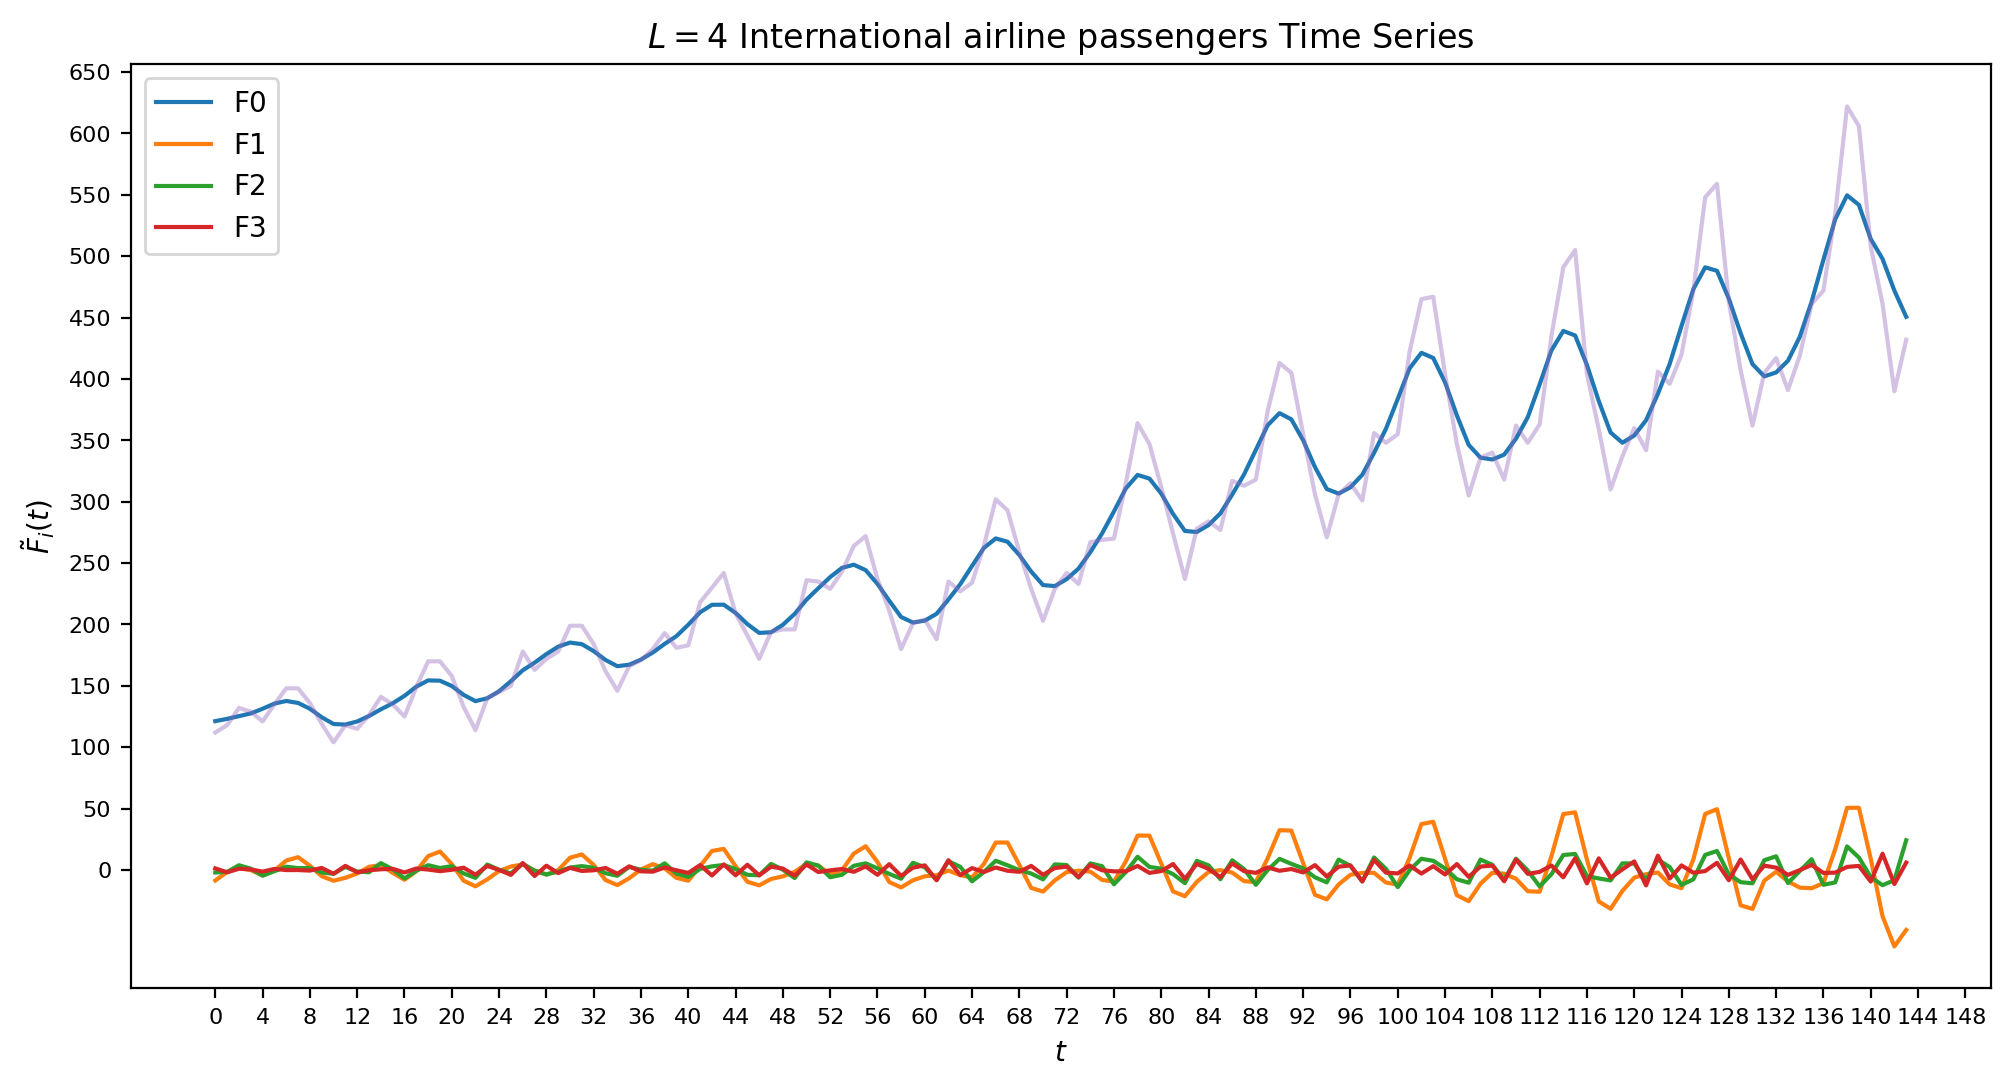

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi = 200)
plt.xticks(range(0, 160, 4))
plt.yticks(range(0, 700, 50))
ax.tick_params(axis='x', labelsize= 8)
ax.tick_params(axis='y', labelsize= 8)
F_ssa_L4 = SSA(passengers, 4)
F_ssa_L4.components_to_df().plot(ax=ax)
F_ssa_L4.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=4$ International airline passengers Time Series")
plt.show()

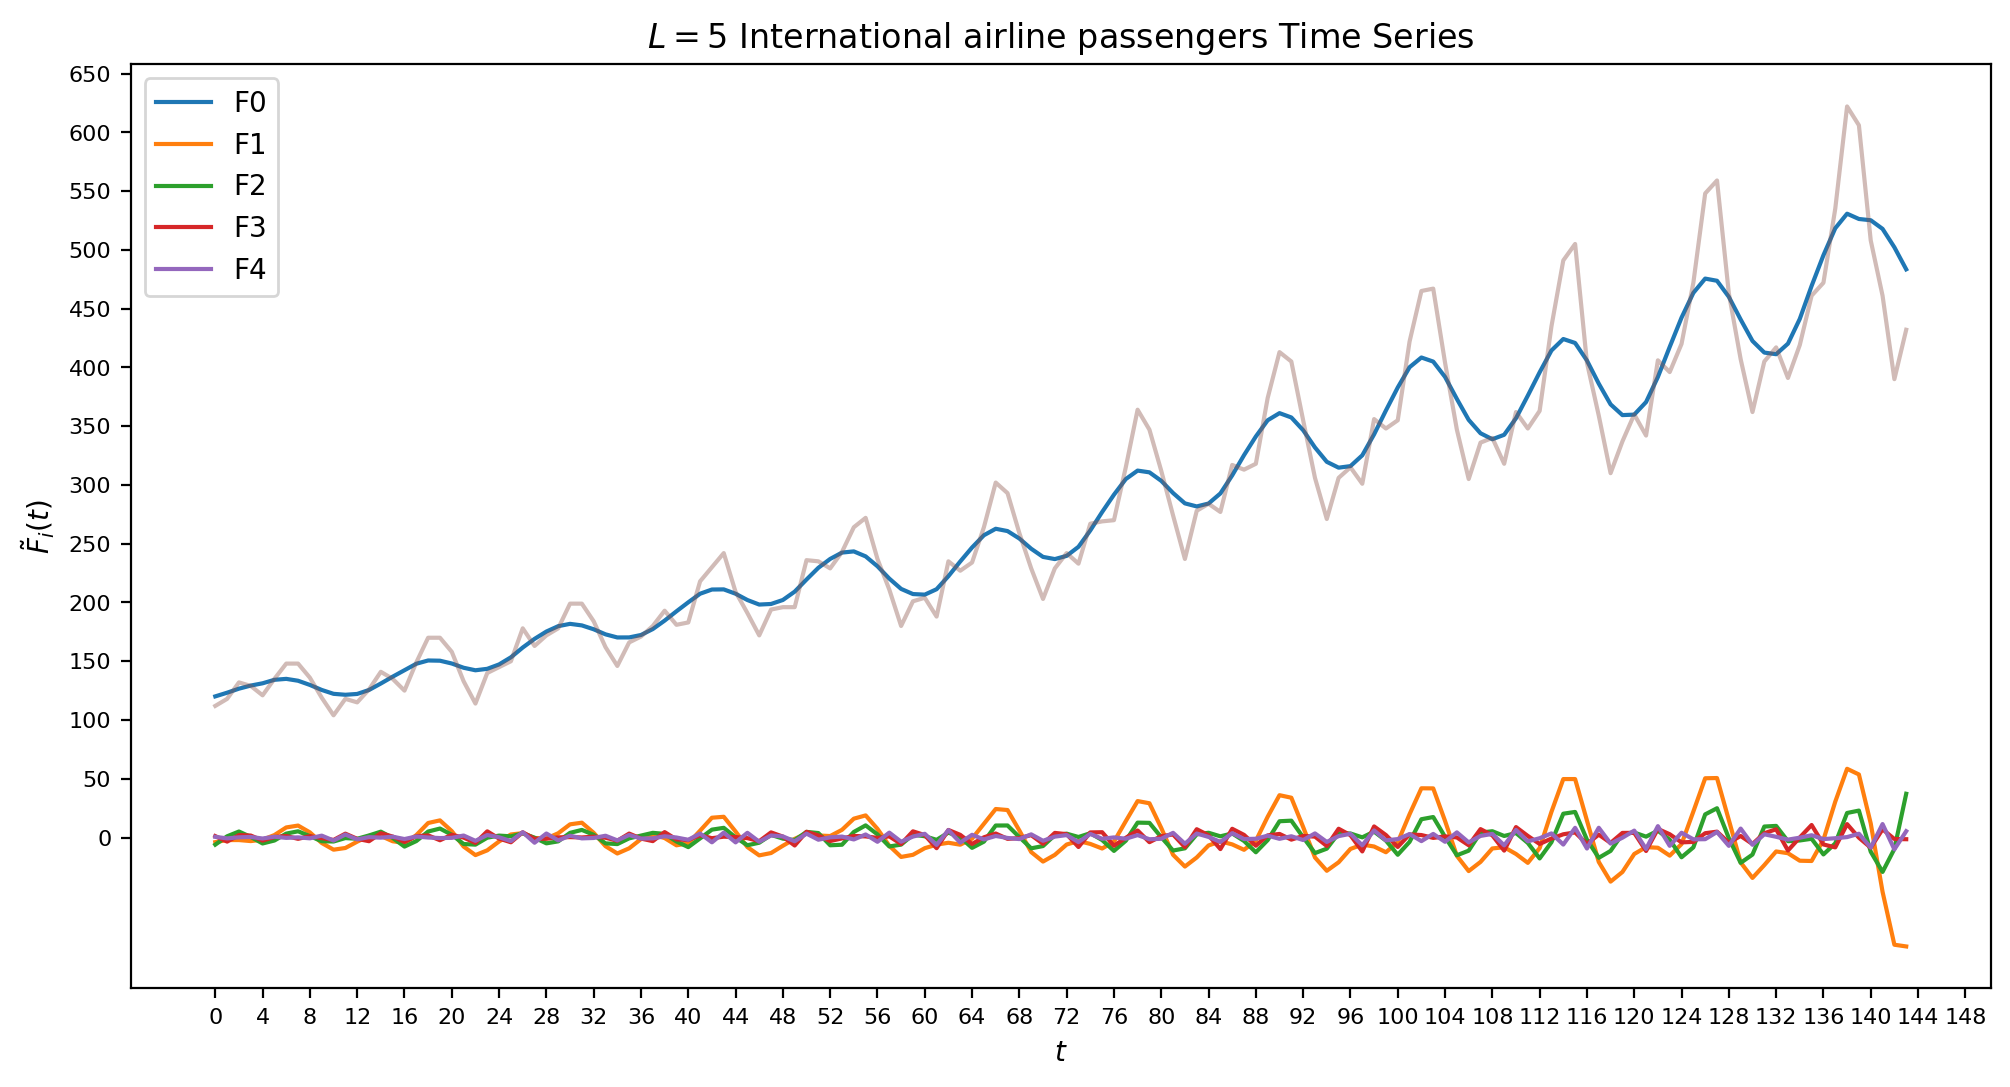

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi = 200)
plt.xticks(range(0, 160, 4))
plt.yticks(range(0, 700, 50))
ax.tick_params(axis='x', labelsize= 8)
ax.tick_params(axis='y', labelsize= 8)
F_ssa_L5 = SSA(passengers, 5)
F_ssa_L5.components_to_df().plot(ax=ax)
F_ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ International airline passengers Time Series")
plt.show()

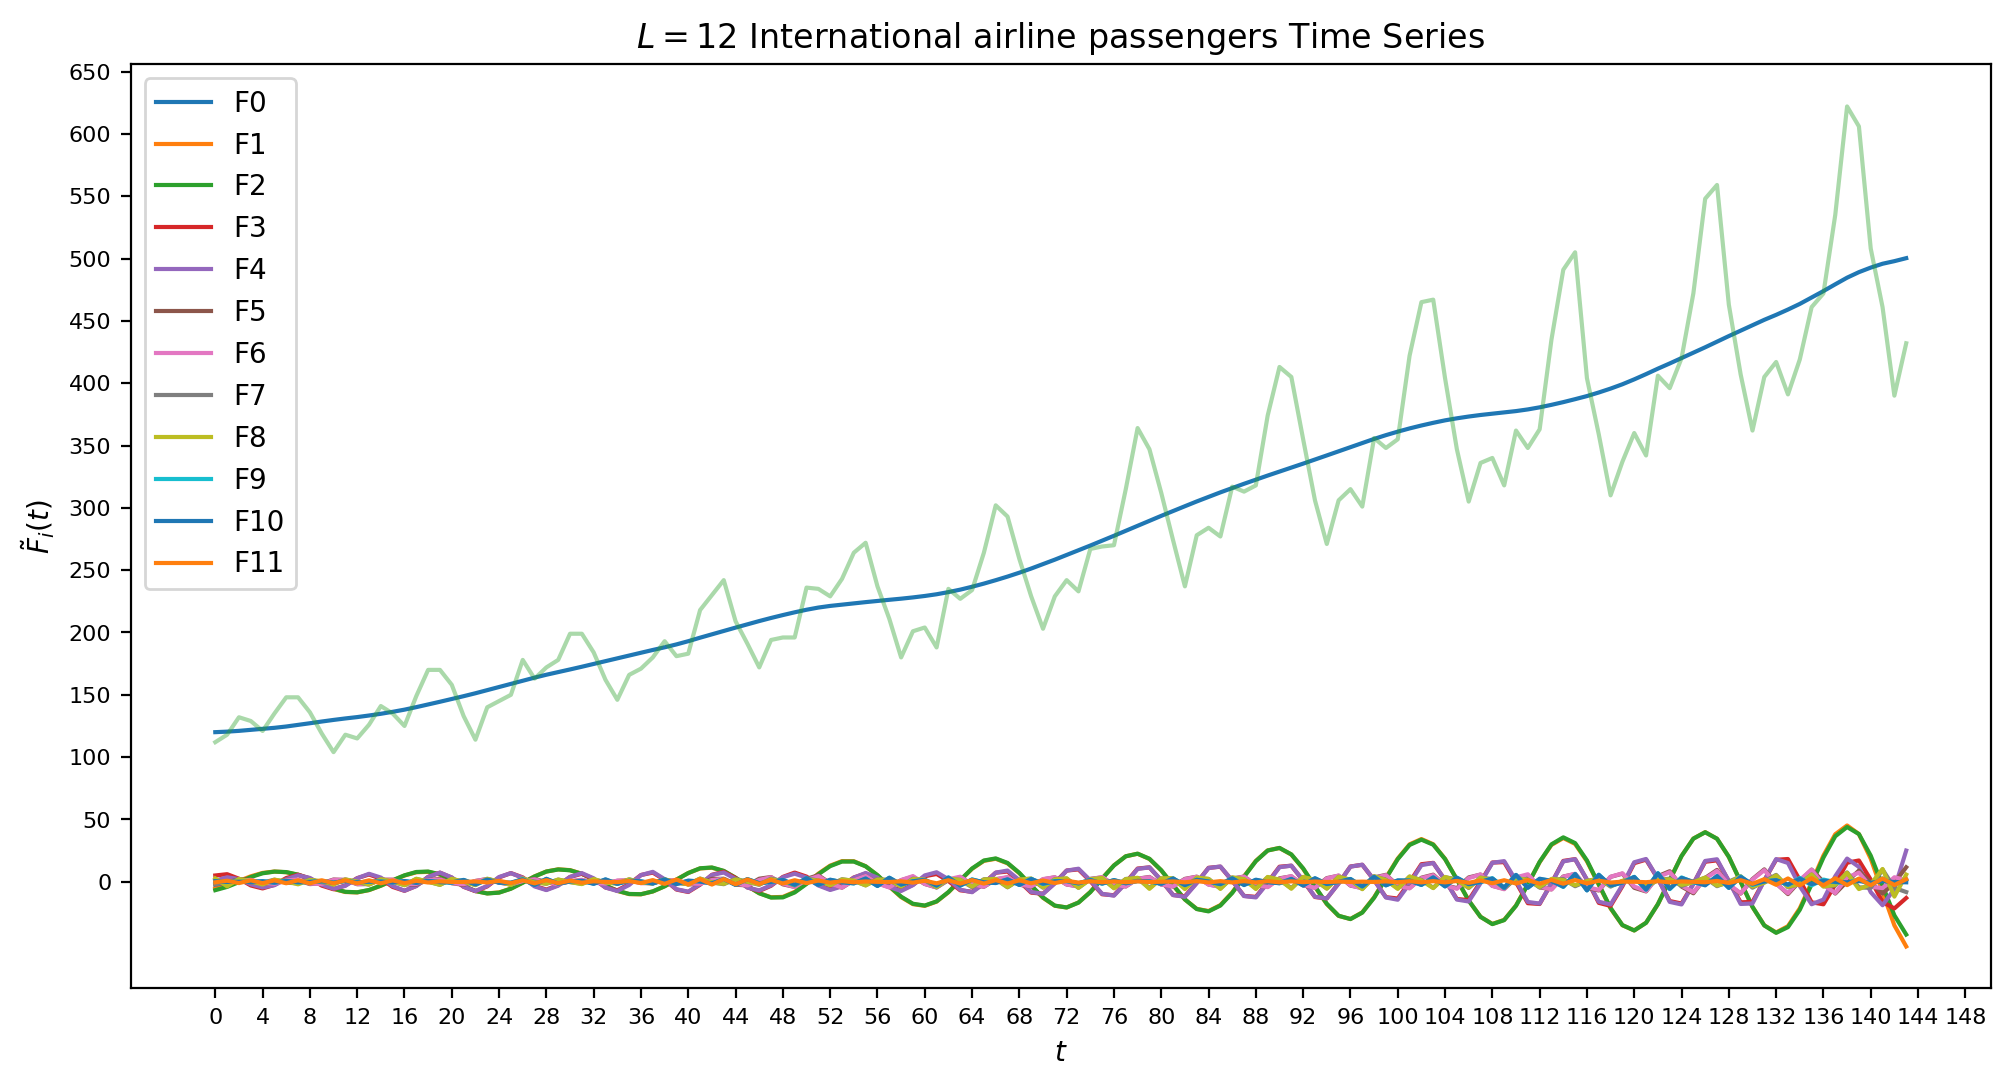

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi = 200)
plt.xticks(range(0, 160, 4))
plt.yticks(range(0, 700, 50))
ax.tick_params(axis='x', labelsize= 8)
ax.tick_params(axis='y', labelsize= 8)
F_ssa_L12 = SSA(passengers, 12)
F_ssa_L12.components_to_df().plot(ax = ax)
F_ssa_L12.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=12$ International airline passengers Time Series")
plt.show()

Сторим матрицу, чтобы определить какие вектора можно объединить 

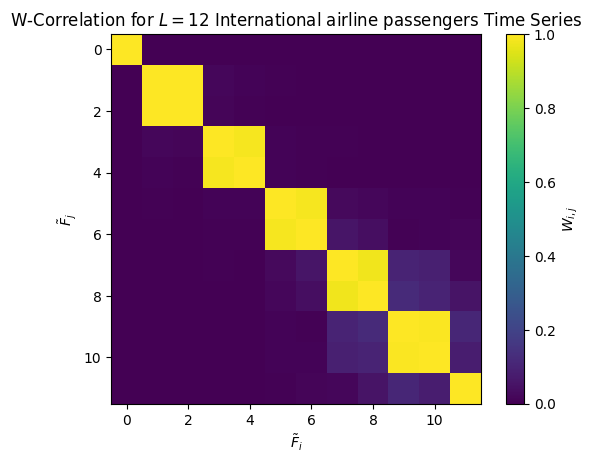

In [ ]:
accel_ssa = SSA(passengers, 12)
accel_ssa.plot_wcorr(max=12)
plt.title("W-Correlation for $L=12$ International airline passengers Time Series")
plt.show()

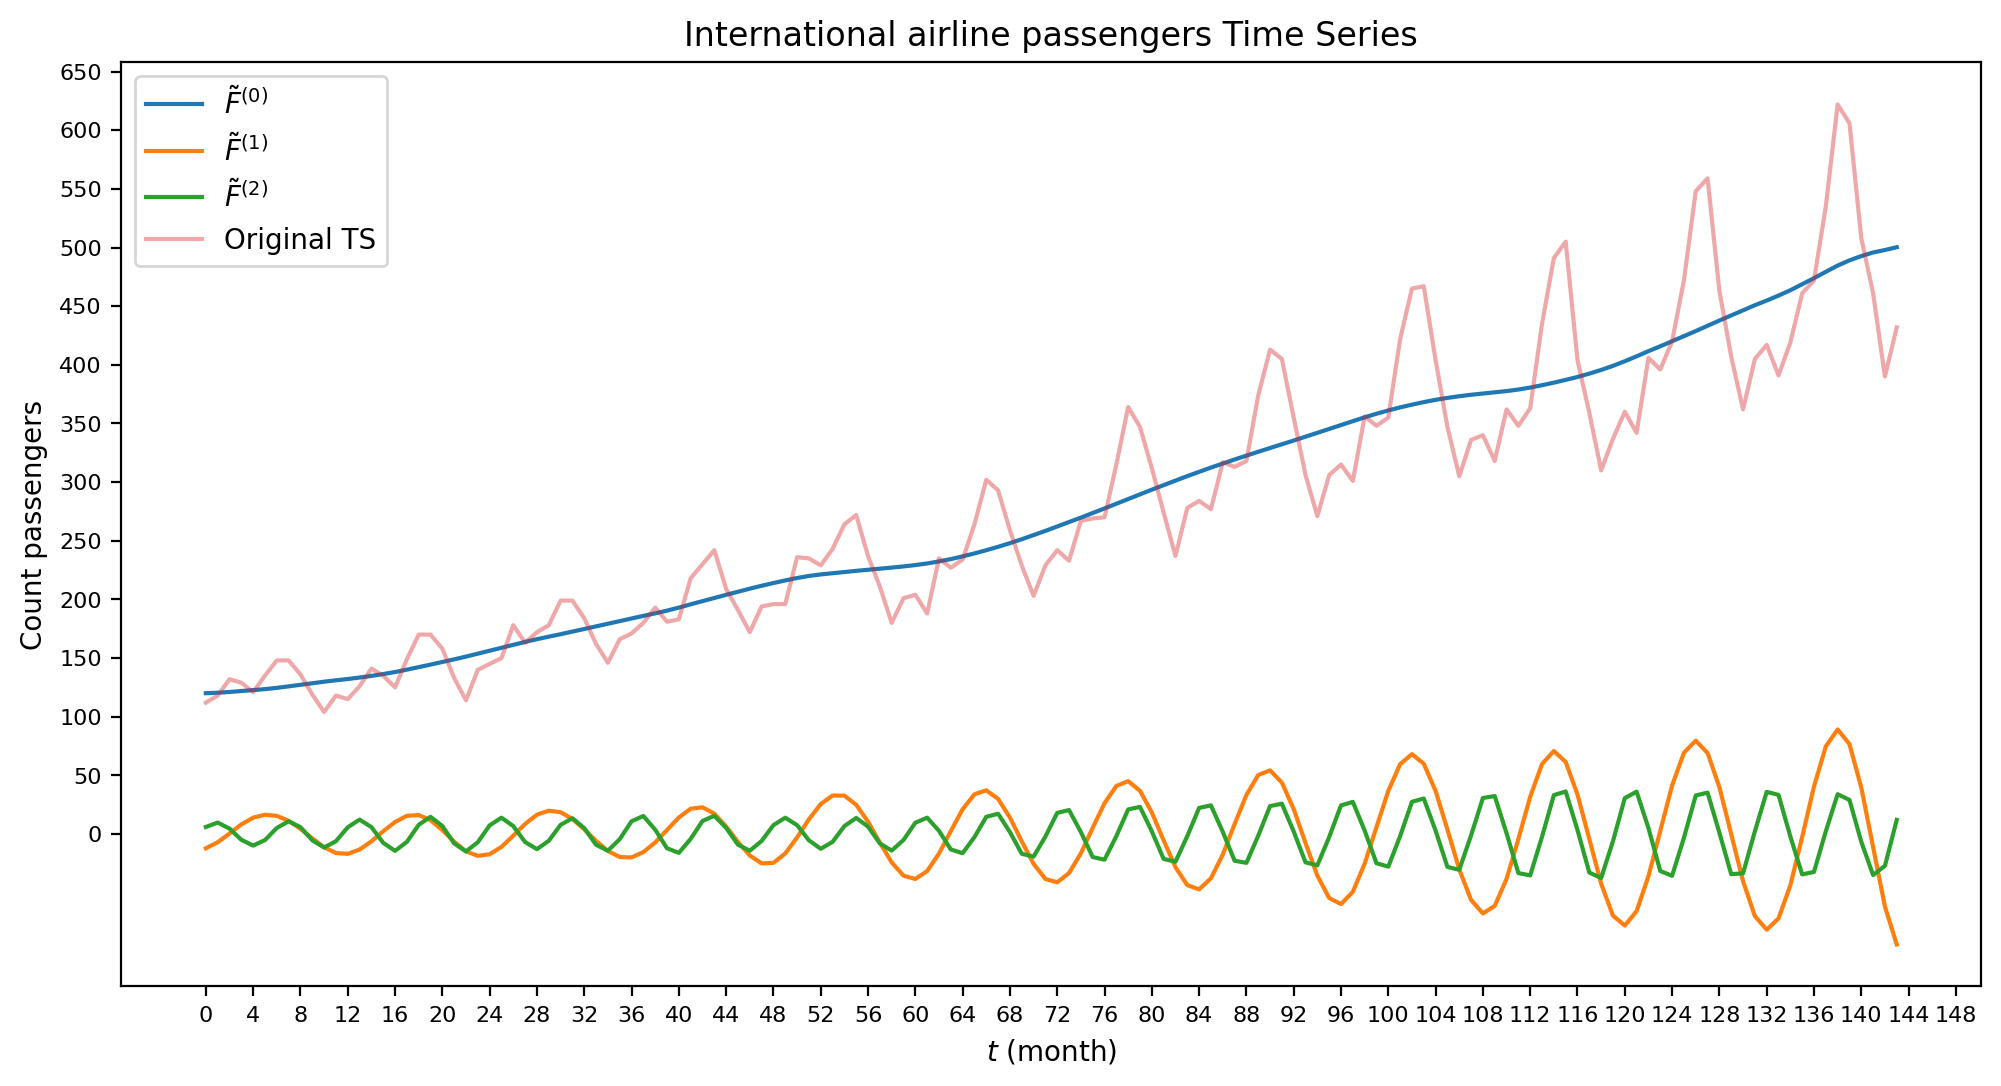

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi = 200)
plt.xticks(range(0, 160, 4))
plt.yticks(range(0, 700, 50))
ax.tick_params(axis='x', labelsize= 8)
ax.tick_params(axis='y', labelsize= 8)
accel_ssa.reconstruct(0).plot(ax = ax)
accel_ssa.reconstruct([1,2]).plot(ax = ax)
accel_ssa.reconstruct([3,4]).plot(ax = ax)
accel_ssa.orig_TS.plot(alpha=0.4,ax = ax)
plt.title("International airline passengers Time Series")
plt.xlabel(r"$t$ (month)")
plt.ylabel("Count passengers")
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3)] + ["Original TS"]
plt.legend(legend)
plt.show()

С помощью Singular Spectrum Analysis (SSA) нам удалось выделить тренд(F0) и две периодичности(F1, F2)